In [1]:
import torch
import numpy as np
import os
from pathlib import Path

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.linalg import sqrtm

from bliss.models.galaxy_flow import CenteredGalaxyLatentFlow
from bliss.models.galaxy_net import OneCenteredGalaxyAE
from bliss.datasets.galsim_galaxies import SDSSGalaxies

In [2]:

os.chdir("../..")

In [106]:
#galaxy_ae = OneCenteredGalaxyAE.load_from_checkpoint("./models/sdss_autoencoder.ckpt")
galaxy_ae = OneCenteredGalaxyAE.load_from_checkpoint("./output/new_autoencoder/default/vae_dim16_noisier_wn/checkpoints/epoch=9109-val_loss=870463.375.ckpt")

In [107]:
from matplotlib import pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [108]:
n_samples = 24
images = galaxy_ae.sample(n_samples)

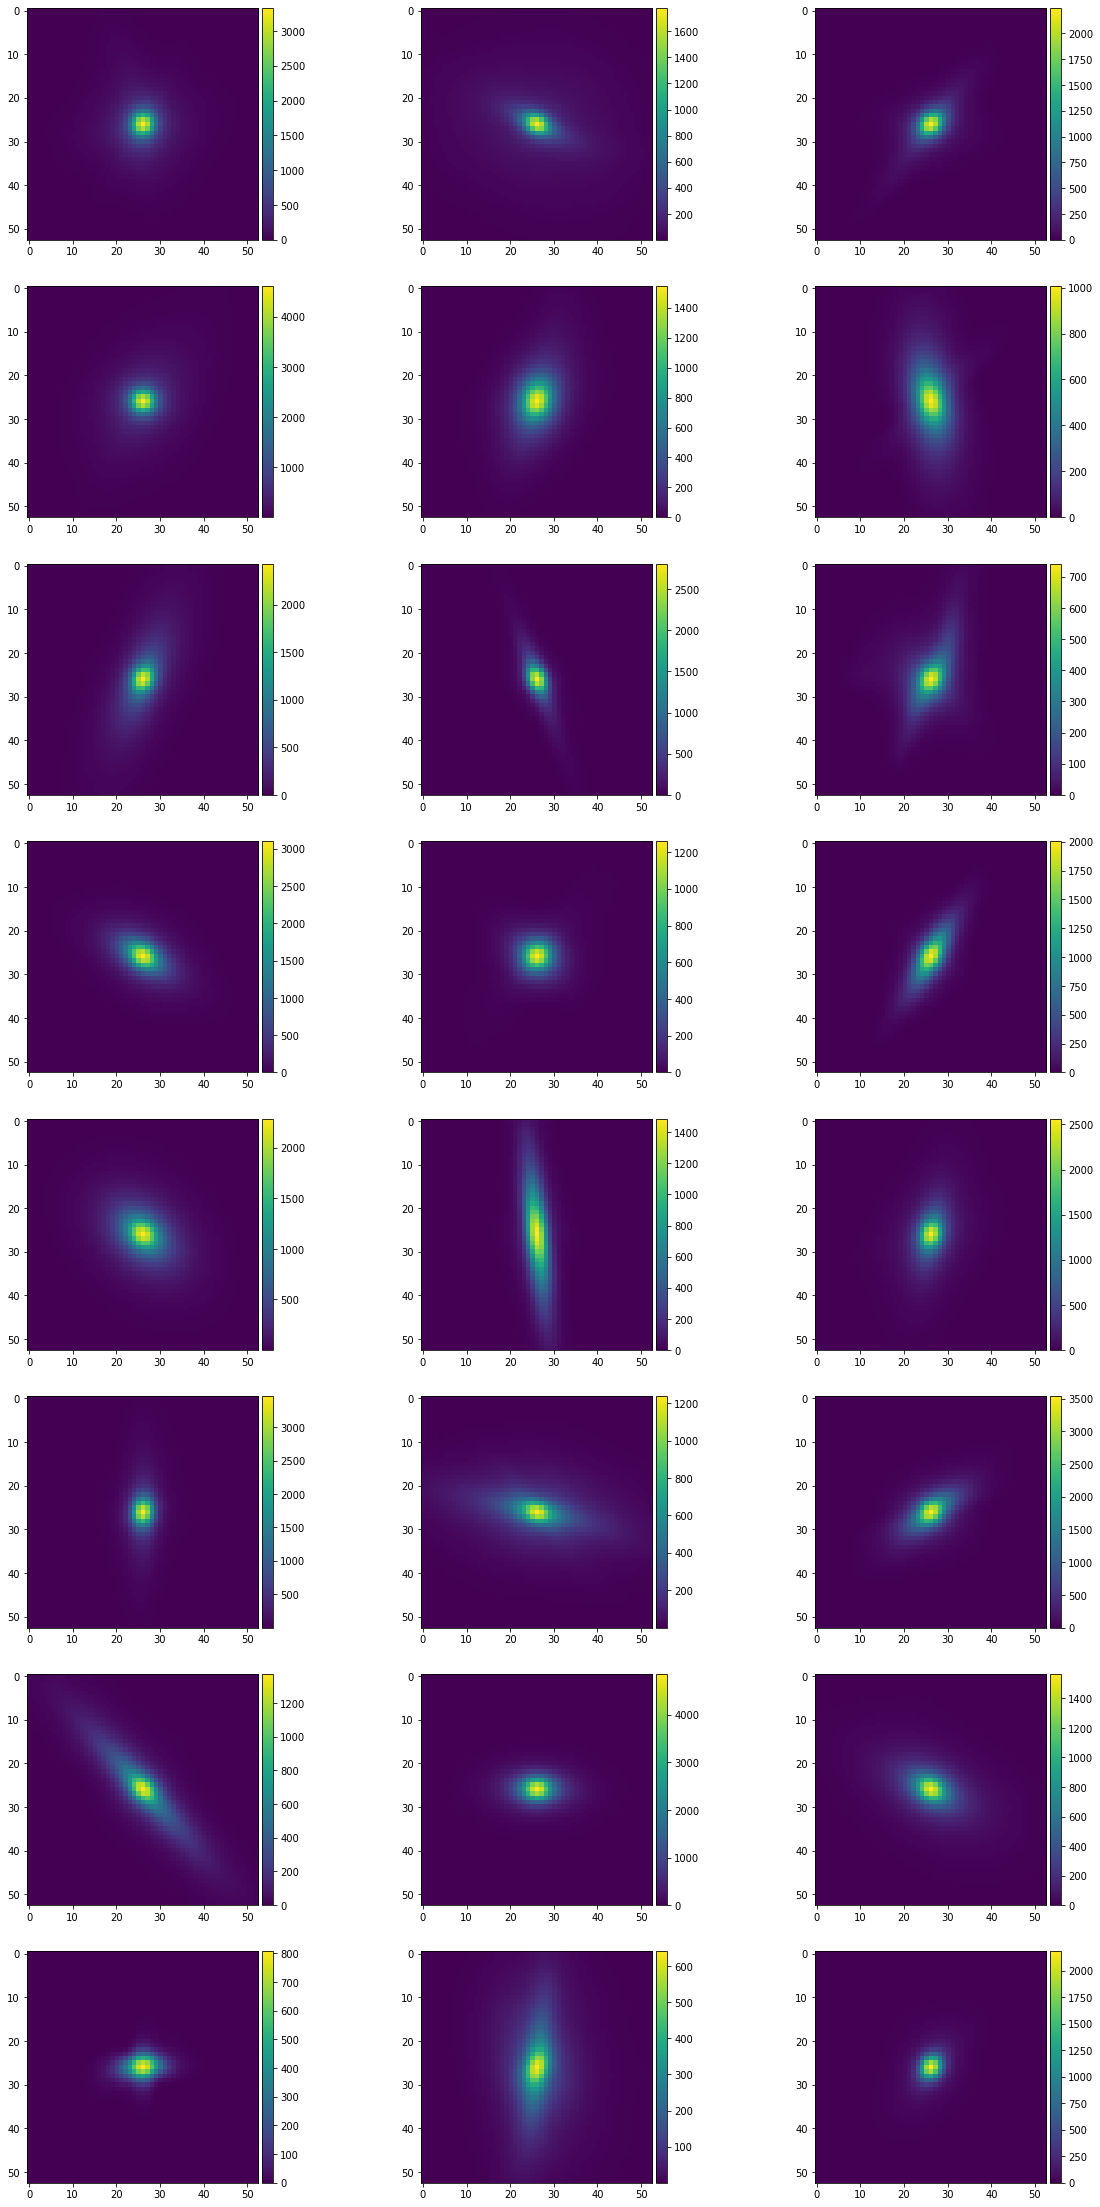

In [109]:
%matplotlib inline
fig, axes = plt.subplots(nrows=n_samples//3, ncols=3, figsize=(20, 20 * (n_samples//12)))
for (i, ax) in enumerate(axes.flatten()):
    im = ax.imshow(images[i, 0].detach().numpy())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    #im = ax.matshow(image, vmin=vmin, vmax=vmax)
    fig.colorbar(im, cax=cax, orientation="vertical")
#plt.imshow(images[1,0].detach().numpy())

In [ ]:
galaxy_ae.sample_latent(n_samples).shape

In [8]:
psf_image_file = Path("./data") / "psField-000094-1-0012-PSF-image.npy"

In [9]:
dataset = SDSSGalaxies(noise_factor=1.0, psf_image_file=psf_image_file)
dataloader = dataset.train_dataloader()

In [86]:
z = galaxy_ae.generate_latents(dataloader, 10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.46s/it]


In [87]:
z.shape

torch.Size([640, 16])

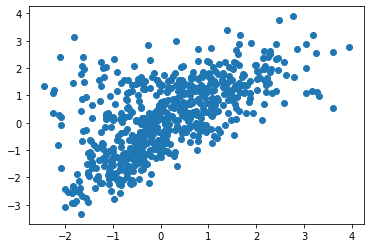

In [88]:
%matplotlib inline
plt.scatter(z[:, 1], z[:, 2])

In [89]:
mu = z.mean(0)

In [90]:
sigma = np.cov(z.transpose(1,0))


In [91]:
sighalf = sqrtm(sigma)

In [92]:
z2 = np.matmul(z - mu, np.linalg.inv(sighalf))

In [93]:
z2.shape

torch.Size([640, 16])

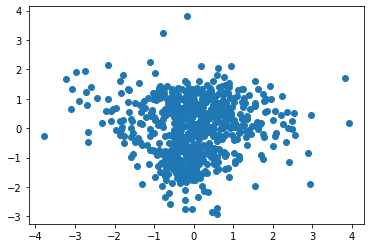

In [94]:
%matplotlib inline
plt.scatter(z2[:, 1], z2[:, 2])

In [98]:
galaxy_flow = CenteredGalaxyLatentFlow.load_from_checkpoint("./output/new_flow_2/default/flow_vae16/checkpoints/epoch=439-val_loss=17.862.ckpt")

In [99]:
z3 = galaxy_flow.flow.transform_to_noise(z).detach()

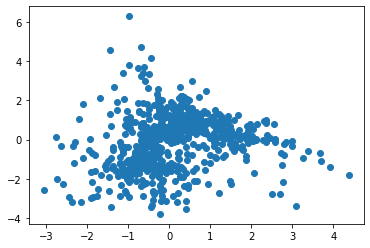

In [100]:
%matplotlib inline
plt.scatter(z3[:, 1], z3[:, 2])

In [49]:
galaxy_ae.latent_flow = galaxy_flow.flow

In [78]:
class MVNormalModule(torch.nn.Module):
    def __init__(self, mu, sigma):
        self.dist = torch.distributions.MultivariateNormal(mu, sigma)
        
    def sample(self, n_samples):
        return self.dist.sample([n_samples])

In [80]:
dist2 = MVNormalModule(mu, torch.tensor(sigma, dtype=torch.float32))
dist2.sample(5).shape

torch.Size([5, 16])

In [102]:
dist2.dist.log_prob(z).mean()

tensor(-20.9876)

In [81]:
galaxy_ae.latent_flow = dist2

In [103]:
images = galaxy_ae.sample(n_samples)

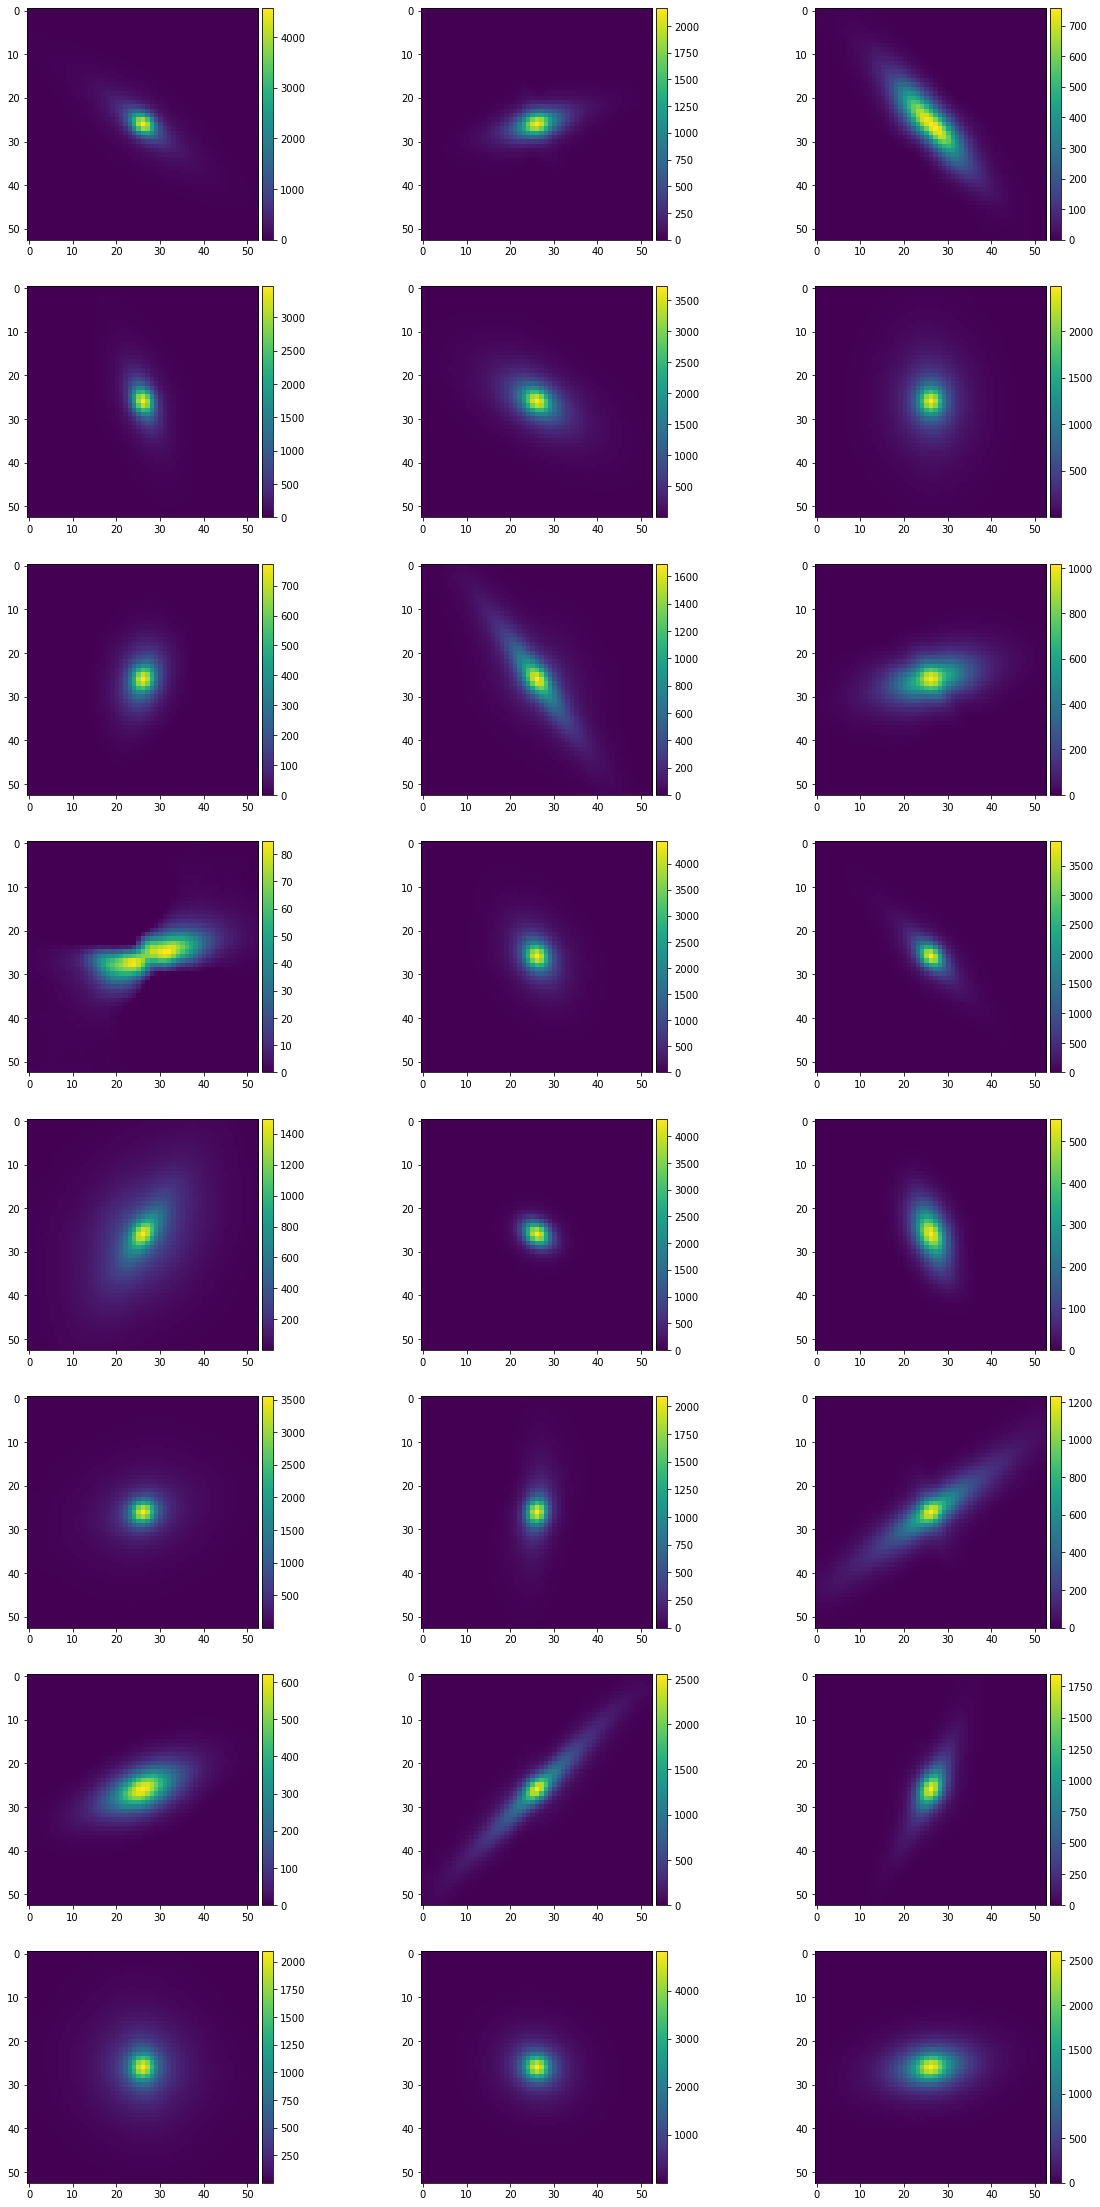

In [104]:
%matplotlib inline
fig, axes = plt.subplots(nrows=n_samples//3, ncols=3, figsize=(20, 20 * (n_samples//12)))
for (i, ax) in enumerate(axes.flatten()):
    im = ax.imshow(images[i, 0].detach().numpy())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    #im = ax.matshow(image, vmin=vmin, vmax=vmax)
    fig.colorbar(im, cax=cax, orientation="vertical")
#plt.imshow(images[1,0].detach().numpy())